# CAFA5

## Data loading

### Imports

In [1]:
import obonet as on
import networkx as nx
import pandas as pd
import numpy as np
from Bio import SeqIO

### Gene ontology

Use [`obonet`](https://github.com/dhimmel/obonet) and [`networkx`](https://networkx.org/) in order to read the Gene Ontology's [`obo` file](https://owlcollab.github.io/oboformat/doc/GO.format.obo-1_4.html) into a graph object.

In [2]:
go = on.read_obo('data/Train/go-basic.obo')
bp_root = go.nodes['GO:0008150']
cc_root = go.nodes['GO:0005575']
mf_root = go.nodes['GO:0003674']

### Train amino acid sequences

Use [biopython](https://biopython.org/) to read the training amino acid sequences in [FASTA format](https://en.wikipedia.org/wiki/FASTA_format).

In [3]:
train_seq_records = SeqIO.parse('data/Train/train_sequences.fasta', 'fasta')

In [4]:
next(train_seq_records)

SeqRecord(seq=Seq('MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLK...FIY'), id='P20536', name='P20536', description='P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosylase OS=Vaccinia virus (strain Copenhagen) OX=10249 GN=UNG PE=1 SV=1', dbxrefs=[])

### Train terms

Use [pandas](pandas.pydata.org/) to read the `tsv` file. This file maps the UniProt ID to the Gene Ontology ID.

In [5]:
train_terms_df = pd.read_csv('data/Train/train_terms.tsv', sep='\t')

In [6]:
train_terms_df.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [7]:
train_terms_df.shape

(5363863, 3)

### Train taxonomy

Use [pandas](pandas.pydata.org/) to read the `tsv` file. This file maps the UniProt ID to the [taxonomy ID](https://www.uniprot.org/help/taxonomic_identifier).

In [8]:
train_taxonomy_df = pd.read_csv('data/Train/train_taxonomy.tsv', sep='\t')

In [9]:
train_taxonomy_df.head()

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


In [10]:
train_taxonomy_df.shape

(142246, 2)

### Information accretion weights

Information accretion weights for each GO term. Used to calculate weighted precision and recall for predictions. Use [pandas](pandas.pydata.org/) to read the `txt` file. 

In [11]:
ia_df = pd.read_csv('data/IA.txt', sep='\t', header=None)
ia_df.columns = ['term', 'IA']

In [12]:
ia_df.head()

,term,IA
0,GO:0000001,0.000000
1,GO:0000002,3.103836
2,GO:0000003,3.439404
3,GO:0000011,0.056584
4,GO:0000012,6.400377


In [13]:
ia_df.shape

(43248, 2)

### Merging train taxonomy, terms and IA

Into one dataframe.

In [14]:
train_df = (train_terms_df
            .merge(train_taxonomy_df, on='EntryID')
            .merge(ia_df, on='term')
            .sort_values(by='EntryID')
            .reset_index(drop=True))

In [15]:
train_df.to_csv('data/Train/train_merged.csv')

In [16]:
train_df.head()

,EntryID,term,aspect,taxonomyID,IA
0,A0A009IHW8,GO:0008152,BPO,1310613,1.598544
1,A0A009IHW8,GO:0072526,BPO,1310613,0.236067
2,A0A009IHW8,GO:0046434,BPO,1310613,0.936742
3,A0A009IHW8,GO:0006796,BPO,1310613,0.037438
4,A0A009IHW8,GO:0009166,BPO,1310613,0.025995


In [17]:
train_df.shape

(5363863, 5)

### Test amino acid sequences

In [18]:
test_seq_records = SeqIO.parse('data/Test (Targets)/testsuperset.fasta', format='fasta')

In [19]:
next(test_seq_records)

SeqRecord(seq=Seq('MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSVAYKNVV...GEN'), id='Q9CQV8', name='Q9CQV8', description='Q9CQV8\t10090', dbxrefs=[])

### Taxon list

In [20]:
test_taxon_df = pd.read_csv('data/Test (Targets)/testsuperset-taxon-list.tsv', sep='\t', encoding='ISO-8859-1')

In [21]:
test_taxon_df.head()

,ID,Species
0,9606,homo sapiens[All Names]
1,10090,mus musculus[All Names]
2,10116,Rattus norvegicus
3,3702,Arabidopsis thaliana[All Names]
4,83333,Escherichia coli K-12[all names]


In [22]:
test_taxon_df.shape

(90, 2)

## Exploratory data analysis

Let's look at the distribution of how often a GO term comes up.

In [23]:
term_counts = train_df['term'].value_counts()

<Axes: title={'center': 'Term counts'}, xlabel='Term rank', ylabel='Occurences'>

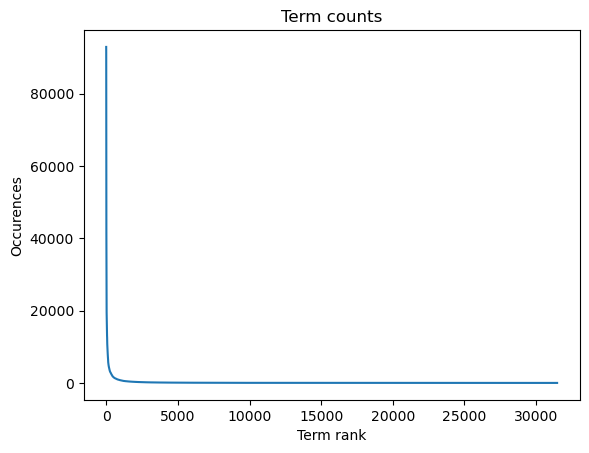

In [24]:
term_counts.reset_index(drop=True).plot.line(logy=False, title='Term counts', xlabel='Term rank', ylabel='Occurences')

<Axes: title={'center': 'Lorenz curve (unweighted)'}, xlabel='Fraction of terms', ylabel='Fraction of usages'>

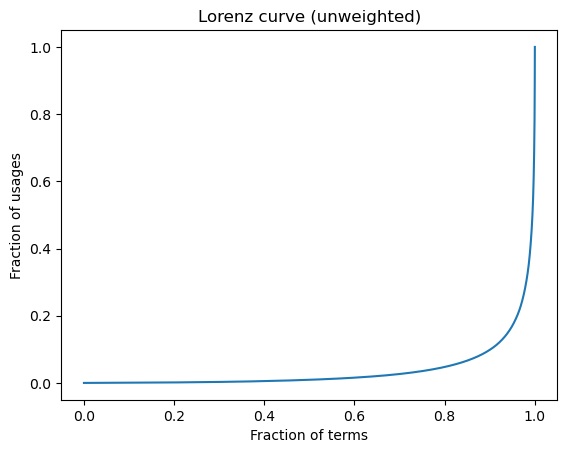

In [25]:
unweighted_pareto = (term_counts
                     .sort_values(ascending=True)
                     .cumsum()) / term_counts.sum()
unweighted_pareto.index = np.linspace(0, 1, len(unweighted_pareto))
unweighted_pareto.plot.line(
    xlabel='Fraction of terms', 
    ylabel='Fraction of usages', 
    title='Lorenz curve (unweighted)', 
)

The Gini coefficient of this Lorenz curve is:

In [26]:
round(sum([(i - v)/len(unweighted_pareto) for (i, v) in unweighted_pareto.items()]) / 0.5, 3)

0.926

In [27]:
term_counts_df = term_counts.reset_index()
term_counts_df.columns = ['term', 'count']
term_counts_df = term_counts_df.merge(ia_df, on='term')
term_counts_df['weighted_count'] = term_counts_df['count'] * term_counts_df['IA']
term_counts_df = term_counts_df.sort_values('weighted_count', ascending=False).reset_index(drop=True)
weighted_pareto = (term_counts_df['weighted_count']
                   .sort_values()
                   .reset_index(drop=True)
                   .cumsum()) / term_counts_df['weighted_count'].sum()
weighted_pareto.index = np.linspace(0, 1, len(weighted_pareto))

In [28]:
term_counts_df.head()

,term,count,IA,weighted_count
0,GO:0050896,31098,1.568071,48763.861747
1,GO:0008152,30448,1.598544,48672.468143
2,GO:0032501,29274,1.655270,48456.364953
3,GO:0032502,28680,1.684844,48321.312613
4,GO:0065007,41457,1.153288,47811.874800


<Axes: title={'center': 'Lorenz curve (weighted)'}, xlabel='Fraction of terms', ylabel='Fraction of weighted usages'>

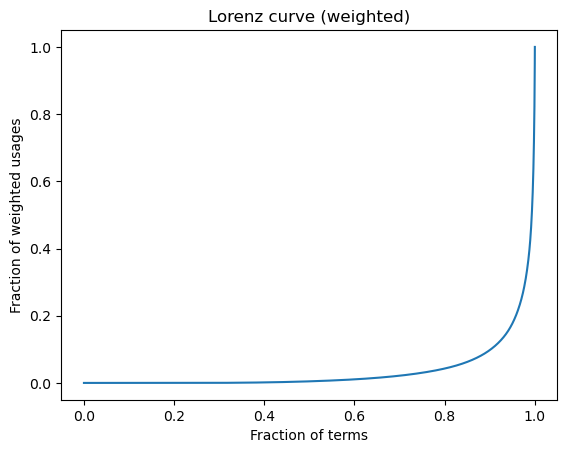

In [29]:
weighted_pareto.plot.line(
    xlabel='Fraction of terms', 
    ylabel='Fraction of weighted usages', 
    title='Lorenz curve (weighted)', 
)

Gini coefficient of the Lorenz curve of the IA-weighted counts.

In [30]:
round(sum([(i - v)/len(weighted_pareto) for (i, v) in weighted_pareto.items()]) / 0.5, 3)

0.929

Higher than the unweighted counts!